Script for computing visuomemory index in block b2
- First, we detect neurons involved in the task computing the t-test between activity during trial vs baseline
- Second, from those neurons we compare the fr response against oposit positions (t-test to check significance)
- Third, compute indices for evaluating if visual or memory neuron  

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
import pandas as pd
from typing import Dict
from collections import defaultdict
from ephysvibe.trials.spikes import firing_rate,sp_constants,plot_raster
from ephysvibe.spike_sorting import config
from ephysvibe.structures.spike_data import SpikeData
from ephysvibe.analysis import circular_stats
from ephysvibe.task import task_constants
import os 
seed=2023

## Def funtions

In [2]:
def get_trials(code,target_codes):
    
    code_order = np.array(['127','126','125','124','123','122','121','120'])
    code_pos = np.where(code_order == code)[0][0]
    next = code_pos + 1
    if next == len(code_order): next = 0  
    next = code_order[next]
    prev = code_pos - 1
    prev = code_order[prev]
    next_idx = np.array(target_codes[next]["trial_idx"])
    prev_idx = np.array(target_codes[prev]["trial_idx"])
    return next_idx,prev_idx

In [3]:
def get_neurons_info(sp_samples:np.ndarray,fix_t:int,neuron_type:np.ndarray,target_codes:Dict,ipsi:np.ndarray,contra:np.ndarray,dur_v:int,st_m:int,end_m:int,neuron_idx:np.ndarray=None,min_trials:int=5,n_spikes_sec:int=5)->pd.DataFrame:
    trial_dur = sp_samples.shape[2]
    if neuron_idx is None:
        neuron_idx = np.arange(0,len(neuron_type))
    codes =  target_codes.keys()
    neurons_info:Dict[str,list] = defaultdict(list)
    i_good,i_mua, n_type = 0,0,0
    for i_neuron,type_neuron in zip(neuron_idx,neuron_type):
        # check and count type of unit
        if type_neuron == 'good':
            i_good+=1
            n_type = i_good
        elif type_neuron == 'mua':
            i_mua+=1
            n_type = i_mua
        for code in codes: # iterate by code'
            trial_idx = np.array(target_codes[code]["trial_idx"])
            trial_idx = trial_idx[(sp_samples[trial_idx,i_neuron].sum(axis=1)>0)]
            n_tr = len(trial_idx)
            larger=False
            p=None
            if n_tr <= min_trials: # if less than x tr, use tr from adjacent locations
                next_idx,prev_idx = get_trials(code,target_codes)
                next_idx = next_idx[(sp_samples[next_idx,i_neuron].sum(axis=1)>0)]
                prev_idx = prev_idx[(sp_samples[prev_idx,i_neuron].sum(axis=1)>0)]
                n_tr_min = np.min([len(next_idx),len(prev_idx)])
                rng = np.random.default_rng(seed=seed)
                next_idx=rng.choice(next_idx, size=n_tr_min, replace=False)
                prev_idx=rng.choice(prev_idx, size=n_tr_min, replace=False)
                trial_idx = np.concatenate([trial_idx,next_idx,prev_idx])
                n_tr = len(trial_idx)
            if n_tr >= min_trials: # if enough tr, compute p value
                mean_visual = sp_samples[trial_idx,i_neuron,fix_t:fix_t+dur_v].mean(axis=1)
                mean_prep = sp_samples[trial_idx,i_neuron,fix_t+st_m:fix_t+end_m].mean(axis=1)
                mean_bl = sp_samples[trial_idx,i_neuron,:fix_t].mean(axis=1)
                v_larger = mean_bl.mean()<mean_visual.mean()
                p_larger = mean_bl.mean()<mean_prep.mean()
                larger= v_larger or p_larger
                p_v = stats.ttest_rel(mean_bl, mean_visual)[1]
                p_p = stats.ttest_rel(mean_bl, mean_prep)[1]
                p = np.min([p_v,p_p])
            if code in ipsi:
                laterality = 'ipsi'
            else:
                laterality='contra'
            neurons_info['code']+=[code]
            neurons_info['p']+=[p]
            neurons_info['larger']+=[larger]  
            neurons_info['laterality']+=[laterality]
            neurons_info['cluster']+=[n_type]
            neurons_info['group']+=[type_neuron]
            neurons_info['array_position']+=[i_neuron]
    neurons_info = pd.DataFrame(neurons_info)
    return neurons_info

In [4]:
def get_responding_neurons(neurons_info:pd.DataFrame,epochs:Dict,before_trial:int,code_samples:np.ndarray,code_numbers:np.ndarray,sp_samples:np.ndarray,
                           align_event:int,target_codes:Dict,n_spikes_sec:np.ndarray= 5)->pd.DataFrame:
    end_time = np.array(epochs['end_time']) + before_trial
    start_time = np.array(epochs['start_time']) + before_trial
    test_involved:Dict[str,list] = defaultdict(list)

    for _, row in neurons_info.iterrows():
        i_neuron = row['array_position']
        code = row['code']
        for i_st, i_end,i_epoch in zip(start_time,end_time,epochs['name']): # iterate by event
            target_t_idx = target_codes[code]["trial_idx"] # select trials with the same stimulus location
            trials_event_time = code_samples[ target_t_idx, np.where(code_numbers[target_t_idx] == align_event)[1]] # moment when the target_on ocurrs in each trial
            shift_sp = SpikeData.indep_roll(sp_samples[target_t_idx,i_neuron], -(trials_event_time-before_trial).astype(int), axis=1) # align trials with (target_on - before_trial)
            # select trials with at least  5sp/sec 
            shift_sp = shift_sp[np.nansum(shift_sp[:,before_trial:before_trial+1100],axis=1)>0]
            # check number of trials 
            if shift_sp.shape[0]>1: # if at least 2 trials, compute and save t-test in pd.DataFrame
                # mean fr during event
                mean_sp = shift_sp[:, i_st:i_end].sum(axis=0)/shift_sp.shape[0]*(i_end-i_st)  # Average fr of all trials 
                # mean fr during fixation
                mean_sp_fix = shift_sp[:, :before_trial].sum(axis=0)/shift_sp.shape[0]*before_trial # Average fr of all trials 
                p=stats.ttest_ind(mean_sp, mean_sp_fix,equal_var=False)[1]
                message = ''
            else:
                p = np.nan
                message = "less than %s spikes/sec"%n_spikes_sec
            test_involved['code']+=[code]
            test_involved['laterality']+=[row['laterality']]
            test_involved['cluster']+=[row['cluster']]
            test_involved['group']+=[row['group']]
            test_involved['array_position']+=[i_neuron]
            test_involved['event']+=[i_epoch]
            test_involved['p']+=[p]
            test_involved['message']+=[message]
    test_involved = pd.DataFrame(test_involved)
        
    return test_involved

In [6]:
def get_rf(th_involved:pd.DataFrame,sp_samples:np.ndarray,ipsi:np.ndarray,contra:np.ndarray,target_codes:Dict,dur_v:int,st_m:int,end_m:int,n_spikes_sec:np.ndarray= 5,min_trials:int=5)->pd.DataFrame:

    test_rf:Dict[str,list] = defaultdict(list)
    for _, row in th_involved.iterrows():
        p=np.nan
        larger = False
        i_neuron = row['array_position']
        code = row['code']
 
        if code in ipsi:
            idx = np.where(ipsi == code)[0]
            opposite_code = contra[idx][0]
        else:
            idx = np.where(contra == code)[0]
            opposite_code = ipsi[idx][0]
        # code
        code_t_idx = np.array(target_codes[code]["trial_idx"]) # select trials with the same stimulus
        code_t_idx = code_t_idx[(sp_samples[code_t_idx,i_neuron].sum(axis=1)>0)]
        if code_t_idx.shape[0]<min_trials:
            next_idx,prev_idx = get_trials(code,target_codes)
            next_idx = next_idx[(sp_samples[next_idx,i_neuron].sum(axis=1)>0)]
            prev_idx = prev_idx[(sp_samples[prev_idx,i_neuron].sum(axis=1)>0)]
            n_tr_min = np.min([len(next_idx),len(prev_idx)])

            rng = np.random.default_rng(seed=seed)
            next_idx=rng.choice(next_idx, size=n_tr_min, replace=False)
            prev_idx=rng.choice(prev_idx, size=n_tr_min, replace=False)
            code_t_idx = np.concatenate([code_t_idx,next_idx,prev_idx])  
            code_t_idx = code_t_idx[(sp_samples[code_t_idx,i_neuron].sum(axis=1)>0)]

        # opposite_code
        oppos_t_idx = np.array(target_codes[opposite_code]["trial_idx"]) # select trials with the same stimulus
        oppos_t_idx = oppos_t_idx[(sp_samples[oppos_t_idx,i_neuron].sum(axis=1)>0)]
        if oppos_t_idx.shape[0]<min_trials:
            next_idx,prev_idx = get_trials(opposite_code,target_codes)
            next_idx = next_idx[(sp_samples[next_idx,i_neuron].sum(axis=1)>0)]
            prev_idx = prev_idx[(sp_samples[prev_idx,i_neuron].sum(axis=1)>0)]
            n_tr_min = np.min([len(next_idx),len(prev_idx)])
            rng = np.random.default_rng(seed=seed)
            next_idx=rng.choice(next_idx, size=n_tr_min, replace=False)
            prev_idx=rng.choice(prev_idx, size=n_tr_min, replace=False)
            oppos_t_idx = np.concatenate([oppos_t_idx,next_idx,prev_idx])  
            oppos_t_idx = oppos_t_idx[(sp_samples[oppos_t_idx,i_neuron].sum(axis=1)>0)]
                   

        if code_t_idx.shape[0]>=min_trials and oppos_t_idx.shape[0]>=min_trials: 
            sp_code = sp_samples[code_t_idx,i_neuron]
            sp_oppos = sp_samples[oppos_t_idx,i_neuron]
            # visual
            mean_sp_code = sp_code[:, :dur_v].mean(axis=1)
            mean_sp_opposite = sp_oppos[:, :dur_v].mean(axis=1)
            p_v = stats.ttest_ind(mean_sp_code, mean_sp_opposite)[1]
            v_larger = mean_sp_code.mean()>mean_sp_opposite.mean()
            # preparatory
            mean_sp_code = sp_code[:, st_m:end_m].mean(axis=1)
            mean_sp_opposite = sp_oppos[:, st_m:end_m].mean(axis=1)
            p_p = stats.ttest_ind(mean_sp_code, mean_sp_opposite)[1]
            p_larger = mean_sp_code.mean()>mean_sp_opposite.mean()
            p = np.min([p_v,p_p])
            larger = v_larger or p_larger
 
        test_rf['code']+=[code]
        test_rf['array_position']+=[i_neuron]
        test_rf['p']+=[p ]  
        test_rf['larger']+=[larger]  
        test_rf['p_v']+=[p_v ]  
        test_rf['v_larger']+=[v_larger] 
        test_rf['p_p']+=[p_p ]  
        test_rf['p_larger']+=[p_larger] 
        test_rf['cluster']+=[row['cluster']]
        test_rf['group']+=[row['group']]
    test_rf = pd.DataFrame(test_rf)
    return test_rf

In [7]:
def moving_average(data:np.ndarray,win:int, step:int=1)-> np.ndarray:
    d_shape=data.shape
    d_avg = np.zeros((d_shape[0],int(np.floor(d_shape[1]/step))))
    count = 0
    for i_step in np.arange(0,d_shape[1]-step,step):
        d_avg[:,count] = np.mean(data[:,i_step:i_step+win],axis=1)
        count +=1
    return d_avg

In [11]:
def get_vm_index(th_rf,target_codes,sp_samples,sp_bl,align_event,fix_t,dur_v,st_m,end_m,n_spikes_sec,min_trials):
    test_vm:Dict[str,list] = defaultdict(list)
    for _, row in th_rf.iterrows():
        i_neuron = row['array_position']
        code = row['code']
        vm_index=np.nan
        sig_type=np.nan
        # select trials

        target_t_idx = np.array(target_codes[code]["trial_idx"]) # select trials with the same stimulus
        target_t_idx = target_t_idx[(sp_samples[target_t_idx,i_neuron].sum(axis=1)>0)]
        all_trials_sp = []
        for i_code in target_codes.keys():
            all_trials = np.array(target_codes[i_code]["trial_idx"]) # select trials with the same stimulus
            all_trials = all_trials[(sp_samples[all_trials,i_neuron].sum(axis=1)>0)]
            all_trials = sp_samples[all_trials,i_neuron]#.mean(axis=0)

            all_trials_sp.append([all_trials[:,50:dur_v].mean(),all_trials[:,st_m:end_m].mean()])

        all_trials_sp = np.concatenate(all_trials_sp)
        min_sp = np.nanmin(all_trials_sp)
        max_sp = np.nanmax(all_trials_sp)-min_sp

        if target_t_idx.shape[0]<=min_trials:
            next_idx,prev_idx = get_trials(code,target_codes)
            n_tr_min = np.min([len(next_idx),len(prev_idx)])
            rng = np.random.default_rng(seed=seed)
            next_idx=rng.choice(next_idx, size=n_tr_min, replace=False)
            prev_idx=rng.choice(prev_idx, size=n_tr_min, replace=False)
            target_t_idx = np.concatenate([target_t_idx,next_idx,prev_idx])  
            target_t_idx = target_t_idx[(sp_samples[target_t_idx,i_neuron].sum(axis=1)>0)]
        if target_t_idx.shape[0]>=min_trials:
            sp_code = sp_samples[target_t_idx,i_neuron]# Select trials with at least  5 spikes/sec
            sp_bl_code = sp_bl[target_t_idx,i_neuron,:200]

            sp_trial_avg = sp_code.mean(axis=0)
            v_mean=((sp_trial_avg[ 50:dur_v].mean()-min_sp)/max_sp)
            m_mean=((sp_trial_avg[ st_m:end_m].mean()-min_sp)/max_sp)
            vm_index = (m_mean-v_mean)/(v_mean+m_mean)
            if vm_index <=0: sig_type = "visual"
            else: sig_type="anticipation" 
        # save results
        test_vm['code']+=[code]
        test_vm['array_position']+=[i_neuron]
        test_vm['vm_index']+=[vm_index]
        test_vm['sig_type']+=[sig_type]  
        test_vm['cluster']+=[row['cluster']]
        test_vm['group']+=[row['group']]
        test_vm['p_v']+=[row['p_v'] ]  
        test_vm['v_larger']+=[row['v_larger']] 
        test_vm['p_p']+=[row['p_p'] ]  
        test_vm['p_larger']+=[row['p_larger']] 
    test_vm = pd.DataFrame(test_vm)
    return test_vm

In [12]:
def get_max_fr(target_codes,sp_samples,code_samples,code_numbers,i_n,kernel,win_size,dur_v,e_code_align,test_vm,fs_ds):
    fr_max_visual, fr_max_motor, fr_angle, fr_max_codes = [], [], [], []
    v_significant, m_significant = [], [] 
    for code in target_codes.keys():
        target_t_idx = target_codes[code][
            "trial_idx"
        ]  # select trials with the same stimulus
        trials_s_on = code_samples[target_t_idx,np.where(code_numbers[target_t_idx] == e_code_align)[1]]  
        shift_sp = SpikeData.indep_roll(sp_samples[target_t_idx, i_n],-(trials_s_on).astype(int),axis=1)  # align trials on event
        # select trials with at least one spike
        shift_sp = shift_sp[np.nansum(shift_sp[:,:1100], axis=1) > 5 * 1100 / 1000]
        mean_sp = np.nanmean(shift_sp,axis=0)  # mean of all trials
        if shift_sp.shape[0] == 0:
            conv = np.zeros((1100))
        else:
            conv = np.convolve(mean_sp, kernel, mode="same") * fs_ds
        fr_max_visual.append(np.nanmax(conv[:dur_v]))
        fr_angle.append(target_codes[code]['angle_codes'])
        fr_max_motor.append(np.nanmax(conv[ 700:1100]))
        fr_max_codes.append(np.nanmax(conv[:1100]))
        if code in test_vm[(test_vm["array_position"] == i_n)&(test_vm["p_v"]<0.05)&(test_vm["v_larger"]==True)]["code"].values:
            v_significant.append(True)
        else:
            v_significant.append(False)
        if code in test_vm[(test_vm["array_position"] == i_n)&(test_vm["p_p"]<0.05)&(test_vm["p_larger"]==True)]["code"].values:
            m_significant.append(True)
        else:
            m_significant.append(False)
    return np.array(fr_max_visual),np.array(fr_max_motor),np.array(fr_angle),np.array(fr_max_codes),np.array(v_significant),np.array(m_significant)

## Load data

In [13]:
# load data
filepath = "/envau/work/invibe/USERS/IBOS/data/Riesling/TSCM/OpenEphys/session_struct/lip/spikes/2023-03-17_10-11-51_Riesling_lip_e1_r1_sp.h5"  #2023-02-27_10-50-03 2023-02-09_10-42-54 2023-03-21_10-40-02
s_path = os.path.normpath(filepath).split(os.sep)
data = SpikeData.from_python_hdf5(filepath)

In [14]:
# Select trials and create task frame
block = 2
trial_idx = np.where(np.logical_and(data.trial_error == 0, data.block == block))[0]
print("Number of clusters: %d" % len(data.clustersgroup))

Number of clusters: 10


In [15]:
# Define target codes 
position_codes= {
    # code: [[MonkeyLogic axis], [plot axis]]
    '127': [[10,0],[1,2],[0]],
    '126': [[7,7],[0,2],[45]],
    '125': [[0,10],[0,1],[90]],
    '124': [[-7,7],[0,0],[135]],
    '123': [[-10,0],[1,0],[180]],
    '122': [[-7,-7],[2,0],[225]],
    '121': [[0,-10],[2,1],[270]],
    '120': [[7,-7],[2,2],[315]],
}
# create dict with the trials having each code
target_codes = {}
for key in position_codes.keys():
    trials = []
    code_idx=[]
    for i_trial,code in zip(trial_idx, data.code_numbers[trial_idx]):
        idx=np.where(int(key) == code)[0]
        if len(idx)!=0:
            code_idx.append(idx[0])
            trials.append(i_trial)
    target_codes[key]={'code_idx':code_idx,'trial_idx':trials,'position_codes':position_codes[key][1],'angle_codes':position_codes[key][2][0]}

In [16]:
idx_code=np.where(pd.DataFrame(target_codes).iloc[3]==270)[0][0]
list(target_codes.keys())[idx_code]

'121'

In [17]:
sp_samples = data.sp_samples
neuron_type = data.clustersgroup
code_samples = data.code_samples
code_numbers = data.code_numbers
sp_samples = data.sp_samples
ipsi = np.array(['124','123','122','121'])
contra = np.array(['120','127','126','125'])

fix_t = 200
dur_v = 200
st_m = 700 #800
end_m = 1100
min_trials=3
n_spikes_sec=5
p_threshold = 0.05
vm_threshold = 0.4

In [18]:
align_event = task_constants.EVENTS_B2['target_on']
shifts = code_samples[:,3]  
shifts = shifts[:,np.newaxis]
sp_shift = SpikeData.indep_roll(sp_samples, -(shifts-fix_t).astype(int), axis=2)[:,:,:1100+fix_t]
neurons_info = get_neurons_info(sp_shift,fix_t,neuron_type,target_codes,ipsi,contra,dur_v=dur_v,st_m=st_m,end_m=end_m,neuron_idx=None,min_trials=min_trials,n_spikes_sec=n_spikes_sec)
neurons_info = neurons_info[(neurons_info['p']<0.05)& (neurons_info['larger']==True)] # responding neurons
neurons_info

,code,p,larger,laterality,cluster,group,array_position
2,125,9.106154e-03,True,contra,1,good,0
10,125,8.771397e-05,True,contra,2,good,1
11,124,3.100854e-07,True,ipsi,2,good,1
16,127,2.117335e-04,True,contra,3,good,2
17,126,4.616116e-04,True,contra,3,good,2
19,124,1.743227e-02,True,ipsi,3,good,2
20,123,7.212278e-03,True,ipsi,3,good,2
21,122,1.170301e-03,True,ipsi,3,good,2
22,121,2.354574e-03,True,ipsi,3,good,2
23,120,2.474250e-04,True,contra,3,good,2


### Neurons RF
Check if signif compared to opposite location

In [19]:


shifts = code_samples[:,3]  
shifts = shifts[:,np.newaxis]
sp_shift = SpikeData.indep_roll(sp_samples, -(shifts).astype(int), axis=2)[:,:,:1100]
rf_test = get_rf(neurons_info,sp_shift,ipsi,contra,target_codes,dur_v,st_m,end_m,n_spikes_sec=n_spikes_sec,min_trials=min_trials)  
th_rf = rf_test[np.logical_and(rf_test['p']<p_threshold,rf_test['larger']==True)] # results below threshold
significant_units = th_rf['array_position'].unique()
print('Units showing significant activity: %s'%significant_units)

th_rf

Units showing significant activity: [0 2 3 6 8 9]


,code,array_position,p,larger,p_v,v_larger,p_p,p_larger,cluster,group
0,125,0,2.144199e-03,True,0.351715,True,2.144199e-03,False,1,good
3,127,2,2.931394e-03,True,0.002931,True,3.716883e-01,False,3,good
4,126,2,7.601642e-04,True,0.124908,True,7.601642e-04,False,3,good
6,123,2,2.931394e-03,True,0.002931,False,3.716883e-01,True,3,good
7,122,2,7.601642e-04,True,0.124908,False,7.601642e-04,True,3,good
8,121,2,6.737172e-03,True,0.924708,False,6.737172e-03,True,3,good
9,120,2,1.007971e-03,True,0.236856,True,1.007971e-03,True,3,good
10,127,3,9.415121e-03,True,0.199726,False,9.415121e-03,True,4,good
16,122,6,1.578499e-02,True,0.191265,True,1.578499e-02,True,2,mua
17,127,8,1.935346e-03,True,0.001935,True,7.694685e-03,True,6,good


### Visuomotor index
check whether a neuron is visual, motor or visuomotor comparing the activity during sample presentation vs motor preparation

In [20]:
shifts = code_samples[:,3]  
shifts = shifts[:,np.newaxis]
sp_shift = SpikeData.indep_roll(sp_samples, -(shifts).astype(int), axis=2)[:,:,:1100]
sp_shift_bl = SpikeData.indep_roll(sp_samples, -(shifts-fix_t).astype(int), axis=2)[:,:,:1100+fix_t]
test_vm=get_vm_index(th_rf,target_codes,sp_shift,sp_shift_bl,align_event,fix_t,dur_v,st_m,end_m,n_spikes_sec,min_trials)
test_vm=test_vm[(np.logical_and(test_vm["p_v"]<0.05,test_vm["v_larger"]==True)) | (np.logical_and(test_vm["p_p"]<0.05,test_vm["p_larger"]==True))]
no_dup_vm = test_vm#[test_vm.columns[:-3]].drop_duplicates()
test_vm

,code,array_position,vm_index,sig_type,cluster,group,p_v,v_larger,p_p,p_larger
1,127,2,-0.587940,visual,3,good,0.002931,True,3.716883e-01,False
4,122,2,0.493213,anticipation,3,good,0.124908,False,7.601642e-04,True
5,121,2,0.183673,anticipation,3,good,0.924708,False,6.737172e-03,True
6,120,2,-0.002135,visual,3,good,0.236856,True,1.007971e-03,True
7,127,3,0.670588,anticipation,4,good,0.199726,False,9.415121e-03,True
8,122,6,0.466667,anticipation,2,mua,0.191265,True,1.578499e-02,True
9,127,8,-0.314286,visual,6,good,0.001935,True,7.694685e-03,True
10,126,8,-0.514630,visual,6,good,0.000617,True,5.142566e-02,True
11,120,8,-0.440994,visual,6,good,0.011478,True,2.051140e-01,True
12,126,9,-0.934884,visual,4,mua,0.000001,True,3.183869e-02,False


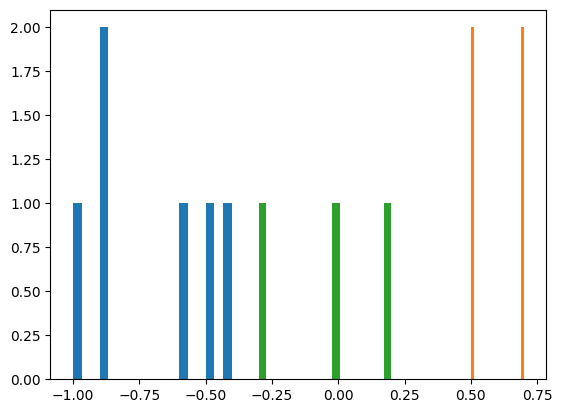

In [21]:
idx_plot = np.around(no_dup_vm['vm_index'].values,1)
plt.hist(idx_plot[idx_plot<=-vm_threshold],bins=18)
plt.hist(idx_plot[idx_plot>=vm_threshold],bins=18)
a=plt.hist(idx_plot[np.logical_and(idx_plot>-vm_threshold,idx_plot<vm_threshold)],bins=18)

### Plot fr and circular max fr/localion

/tmp/ipykernel_108054/202995660.py:12: RuntimeWarning: Mean of empty slice
  mean_sp = np.nanmean(shift_sp,axis=0)  # mean of all trials
/home/INT/losada.c/Documents/codes/EphysVibe/ephysvibe/trials/spikes/plot_raster.py:60: RuntimeWarning: Mean of empty slice.
  mean_sp = shift_sp.mean(axis=0)  # mean of all trials
/home/INT/losada.c/.virtualenvs/EphysVibe-48n-7Gof/lib/python3.8/site-packages/numpy/core/_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_108054/3407500155.py:85: RuntimeWarning: invalid value encountered in divide
  norm_fr_max = np.array(fr_max)/fr_code_max
/tmp/ipykernel_108054/3407500155.py:147: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(0, all_max_conv + max_num_trials * 3)
/tmp/ipykernel_108054/3407500155.py:149: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expandi

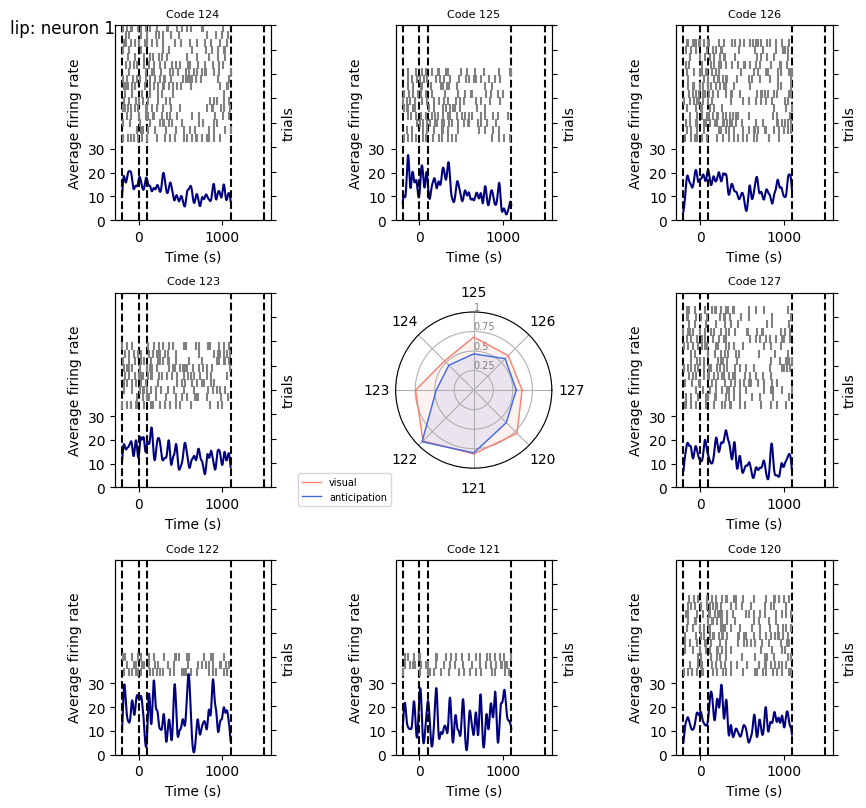

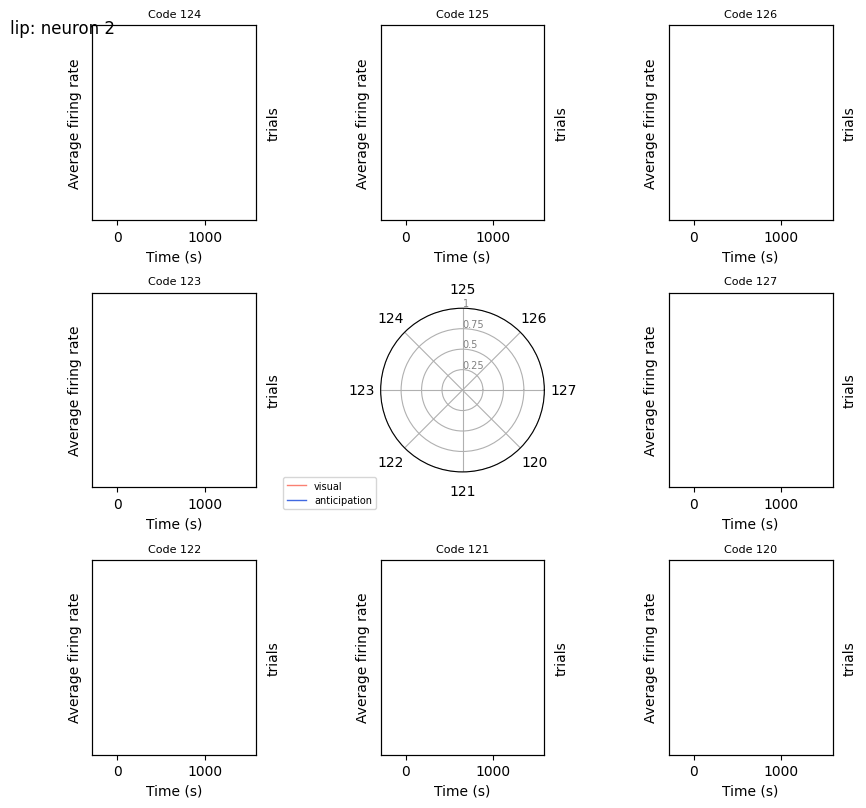

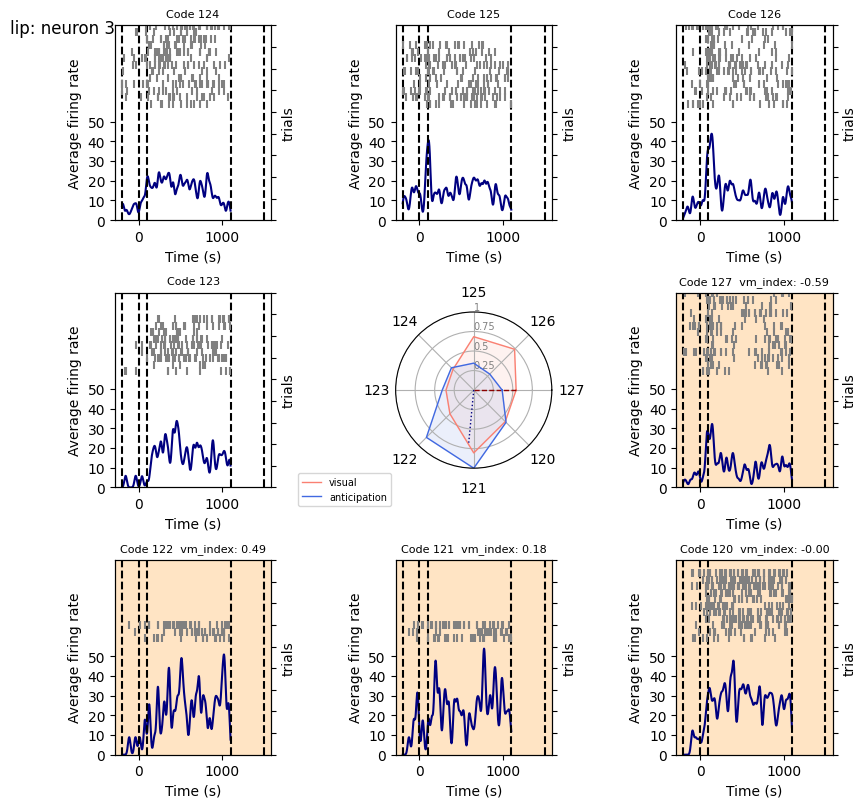

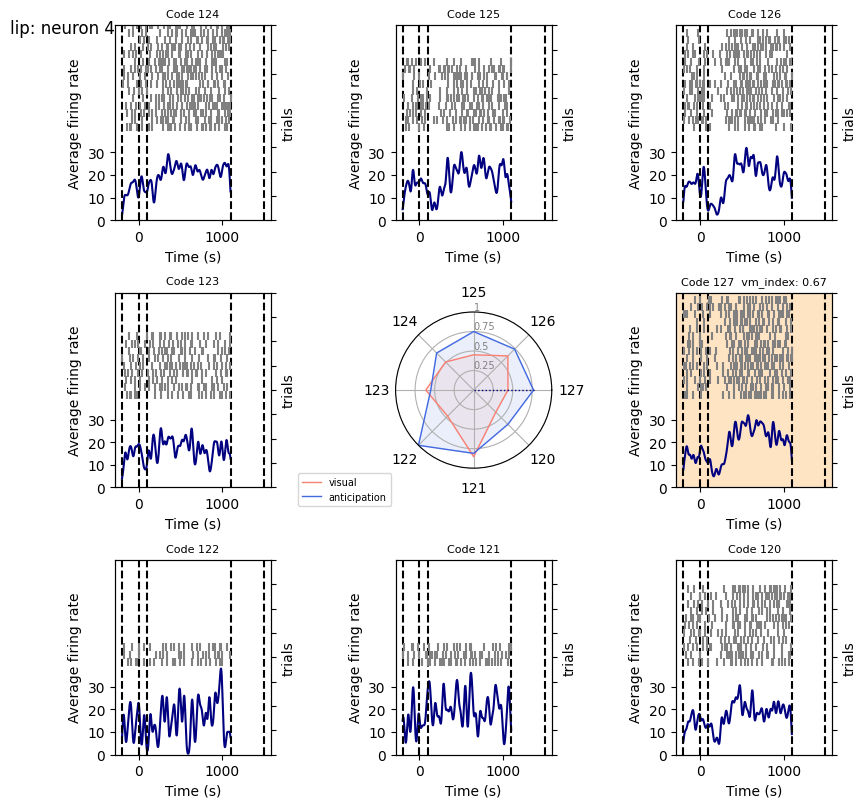

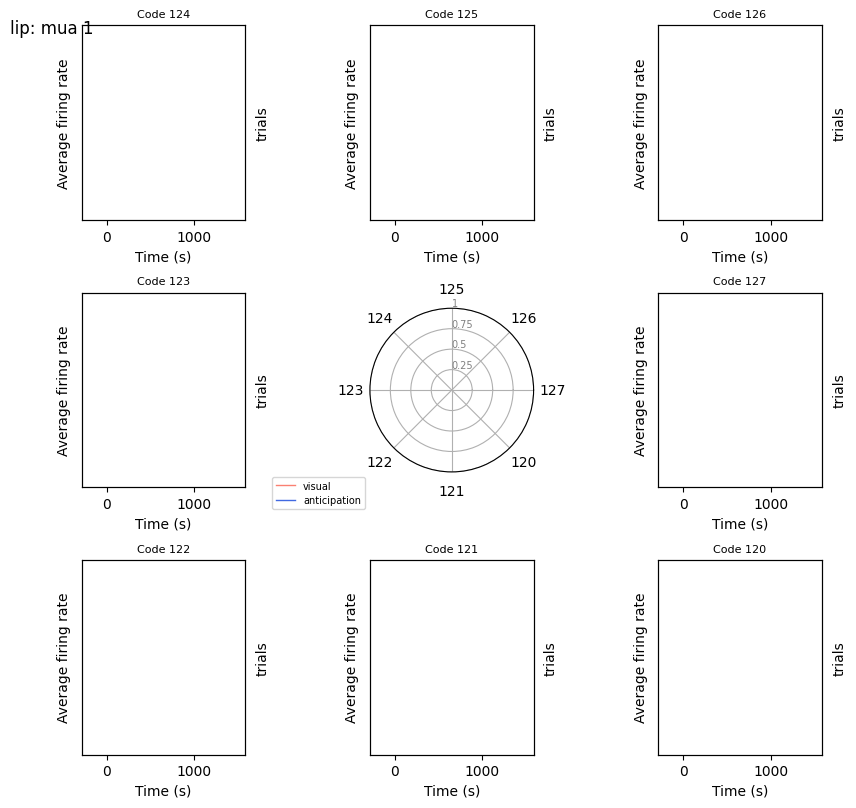

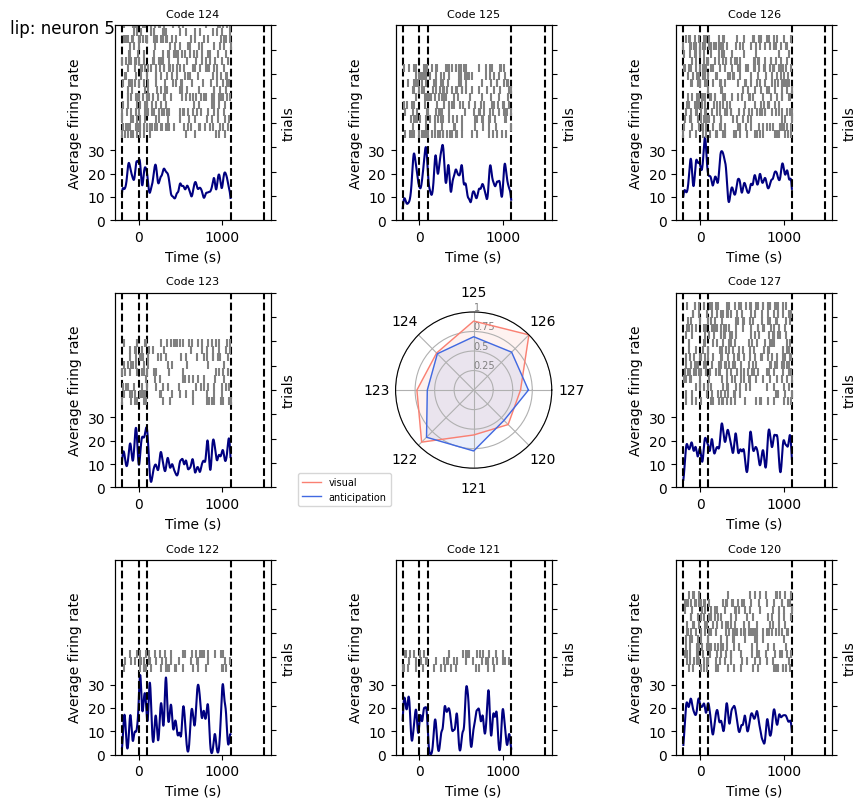

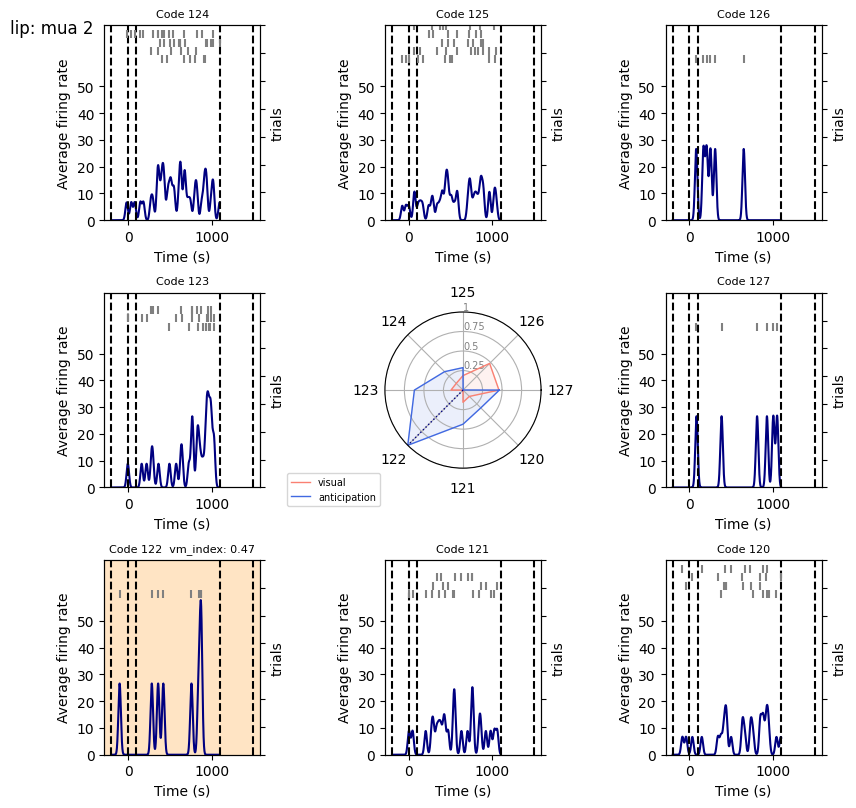

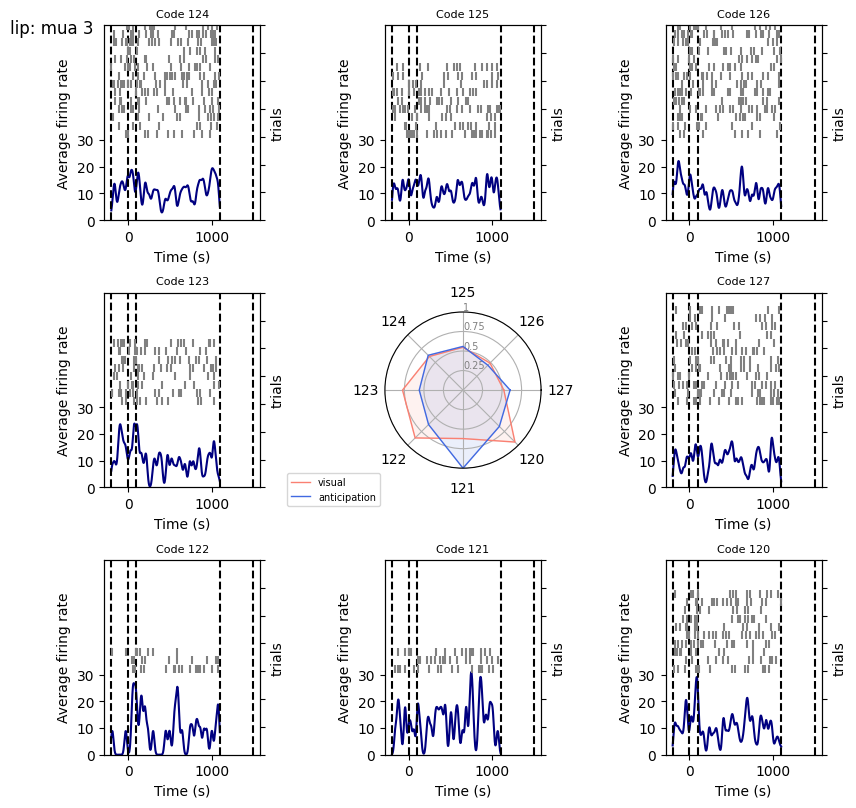

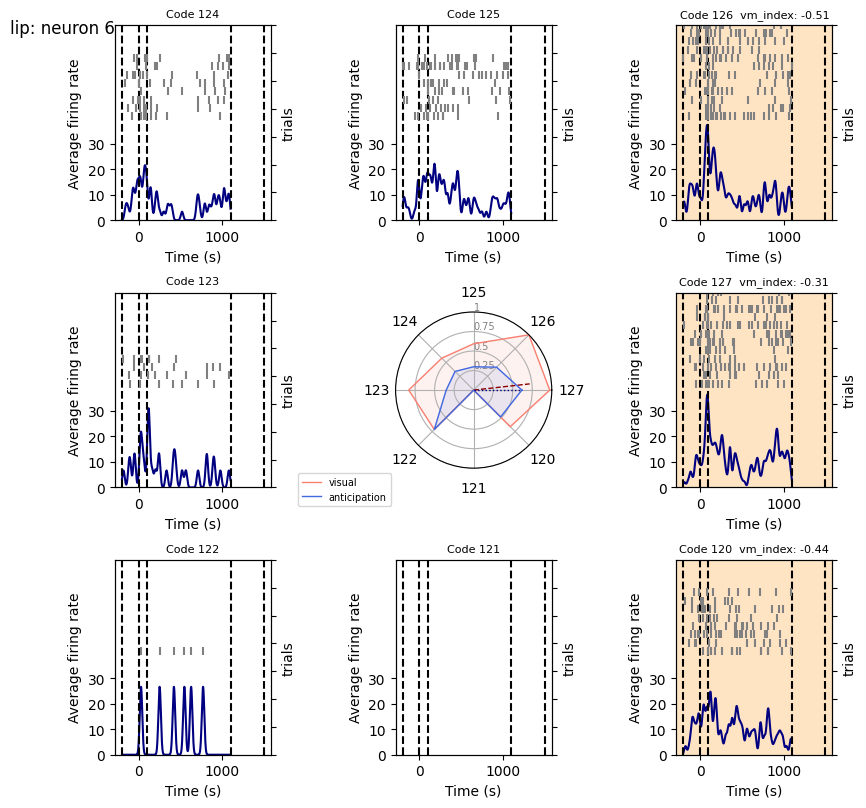

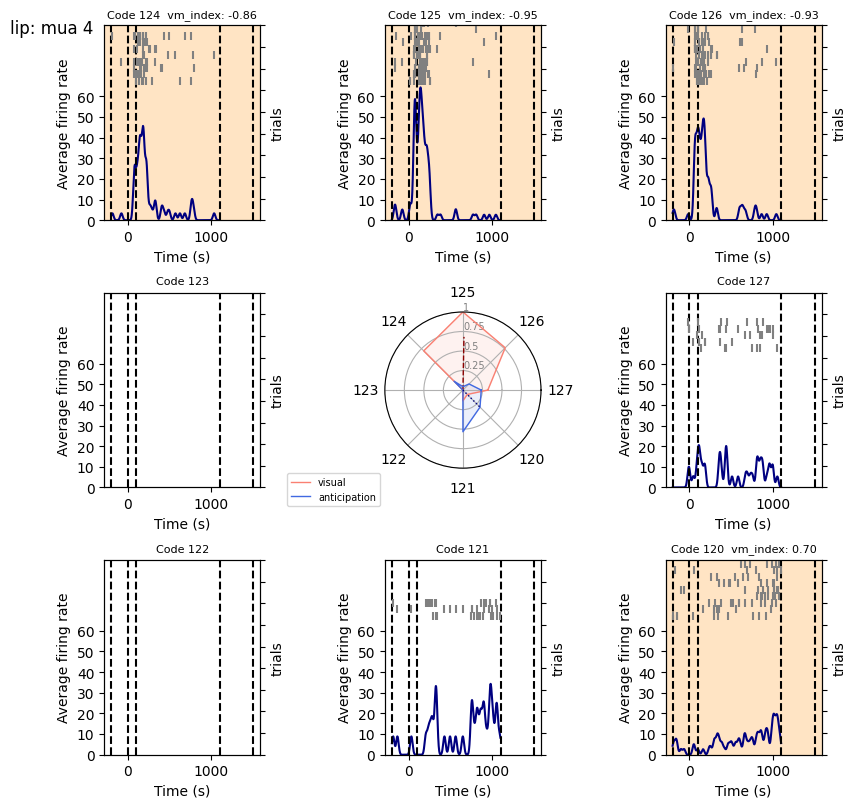

In [22]:
color={'visual':['salmon','darkred','--'],'anticipation':['royalblue','navy',':']}
# kernel parameters
t_before=200
fs_ds = config.FS / config.DOWNSAMPLE
kernel = firing_rate.define_kernel(
    sp_constants.W_SIZE, sp_constants.W_STD, fs=fs_ds
)
win_size = int(sp_constants.W_SIZE * fs_ds)
code_samples=data.code_samples
code_numbers=data.code_numbers
sp_samples=data.sp_samples
e_code_align = task_constants.EVENTS_B2['target_on']
# select only individual neurons
rf_coordinates:Dict[str,list] = defaultdict(list)
i_neuron, i_mua = 1, 1
for i_n, cluster in enumerate(data.clustersgroup): # iterate by units
    if cluster == "good":
        i_cluster = i_neuron
        i_neuron += 1
        cluster = "neuron"
    else:
        i_cluster = i_mua
        i_mua += 1
    fig, _ = plt.subplots(figsize=(8, 8), sharex=True, sharey=True) # define figure
    all_ax, all_ax2,all_max_conv,max_num_trials=plot_raster.plot_activity_location(target_codes,code_samples,code_numbers,sp_samples, i_n, e_code_align, t_before,fs_ds, kernel,no_dup_vm)
    # ------------------ plot spider in the center 
    fr_max_visual,fr_max_motor,fr_angle,fr_max_codes,v_significant,m_significant = get_max_fr(target_codes,sp_samples,code_samples,code_numbers,i_n,kernel,win_size,dur_v,e_code_align,test_vm,fs_ds)
    codes_sig = np.logical_or(m_significant,v_significant)
    fr_code_max = max(fr_max_codes)
    vm_index,vm_index_v_fr,vm_index_p_fr = np.nan,np.nan,np.nan
    code_vm_index,code_index_v_fr,code_index_p_fr = np.nan,np.nan,np.nan
    vm_index_v_max,vm_index_p_max,code_v_max,code_p_max = np.nan,np.nan,np.nan,np.nan

    if np.any(~np.isnan(fr_max_codes[codes_sig])):
        neu_test_vm = test_vm[test_vm["array_position"] == i_n]

        # select vm index of the code with the max fr
        idx_max_all = np.nanargmax(fr_max_codes[codes_sig])
        ang_max_all = fr_angle[codes_sig][idx_max_all]
        idx_code=np.where(pd.DataFrame(target_codes).iloc[3]==ang_max_all)[0][0]
        code = list(target_codes.keys())[idx_code]
        if code in neu_test_vm["code"].values:
            vm_index = neu_test_vm[neu_test_vm['code']==code]['vm_index'].values[0]  
            code_vm_index = code
        if np.any(~np.isnan(fr_max_visual[v_significant])):
            # select vm index max visual fr
            idx_max_all = np.nanargmax(fr_max_visual[v_significant])
            ang_max_all = fr_angle[v_significant][idx_max_all]
            idx_code=np.where(pd.DataFrame(target_codes).iloc[3]==ang_max_all)[0][0]
            code = list(target_codes.keys())[idx_code]
            if code in neu_test_vm["code"].values:
                vm_index_v_fr = neu_test_vm[neu_test_vm['code']==code]['vm_index'].values[0] 
                code_index_v_fr = code
            # select max visual vm index
            ang_max_all = fr_angle[v_significant]
            idx_code=np.where(np.isin(pd.DataFrame(target_codes).iloc[3].values,ang_max_all))[0]
            code = np.array(list(target_codes.keys()))[idx_code]
            vm_index_v_max = neu_test_vm[np.isin(neu_test_vm['code'].values,code)]
            idx_max = np.argmax(np.abs(vm_index_v_max["vm_index"]))
            code_v_max = vm_index_v_max['code'].iloc[idx_max]
            vm_index_v_max = vm_index_v_max['vm_index'].iloc[idx_max]
        if np.any(~np.isnan(fr_max_motor[m_significant])):
            # select vm index max anticipation fr
            idx_max_all = np.nanargmax(fr_max_motor[m_significant])
            ang_max_all = fr_angle[m_significant][idx_max_all]
            idx_code=np.where(pd.DataFrame(target_codes).iloc[3]==ang_max_all)[0][0]
            code = list(target_codes.keys())[idx_code]
            if code in neu_test_vm["code"].values:
                vm_index_p_fr = neu_test_vm[neu_test_vm['code']==code]['vm_index'].values[0] 
                code_index_p_fr = code
            # select max visual vm index
            ang_max_all = fr_angle[m_significant]
            idx_code=np.where(np.isin(pd.DataFrame(target_codes).iloc[3].values,ang_max_all))[0]
            code = np.array(list(target_codes.keys()))[idx_code]
            vm_index_p_max = neu_test_vm[np.isin(neu_test_vm['code'].values,code)]
            idx_max = np.argmax(np.abs(vm_index_p_max["vm_index"]))
            code_p_max = vm_index_p_max['code'].iloc[idx_max]
            vm_index_p_max = vm_index_p_max['vm_index'].iloc[idx_max]

    ax = plt.subplot2grid((3, 3), (1, 1), polar=True)
    fr_angle_rad=((np.array(fr_angle)*2 * np.pi )/360)
    fr_angle_rad = np.concatenate([fr_angle_rad,fr_angle_rad[:1]]) 
    
    for fr_max,event,significant in zip([fr_max_visual, fr_max_motor],['visual','anticipation'],[v_significant,m_significant]):
        norm_fr_max = np.array(fr_max)/fr_code_max
        # compute mean vector only visual or motor
        if np.any(significant):
            rad,ang = circular_stats.mean_vector(radius=norm_fr_max[significant], angle=fr_angle_rad[:-1][significant])
            idx_max = np.nanargmax(fr_max)
            fr_max_n = fr_max[idx_max]
            ang_max_n = fr_angle[idx_max]
        else:
            rad,ang = np.nan,np.nan
            fr_max_n=np.nan
            ang_max_n=np.nan
          
        # compute mean vector of all significant positions/codes
        if np.any(codes_sig):
            rad_all,ang_all = circular_stats.mean_vector(radius=fr_max_codes[codes_sig]/fr_code_max, angle=fr_angle_rad[:-1][codes_sig])
        else:
            rad_all,ang_all = np.nan,np.nan
        # plot max fr
        norm_fr_max = np.concatenate([norm_fr_max,norm_fr_max[:1]])
        ax.set_rlabel_position(90)
        plt.yticks([0.25,0.5,0.75,1], ['0.25','0.5','0.75','1'], color="grey", size=7)
        plt.ylim(0,1)
        plt.xticks(fr_angle_rad[:-1], target_codes.keys())
        ax.plot(fr_angle_rad, norm_fr_max, linewidth=1, linestyle='solid',color=color[event][0], label=event)
        ax.fill(fr_angle_rad, norm_fr_max, alpha=0.1,color=color[event][0])
        # plot mean vector              
        ax.plot([0,ang], [0,rad], linewidth=1, linestyle=color[event][2], color=color[event][1])
        plt.legend(loc='upper right', bbox_to_anchor=(0, 0), prop={'size': 7})
        # add results to df
        rf_coordinates['array_position'] += [i_n] 
        rf_coordinates['event'] += [event]
        rf_coordinates['rad'] += [rad]
        rf_coordinates['ang'] += [ang]
        rf_coordinates['fr_max'] += [fr_max_n]
        rf_coordinates['ang_max'] += [ang_max_n]        
        rf_coordinates['rad_all'] += [rad_all]
        rf_coordinates['ang_all'] += [ang_all]
        rf_coordinates['depth'] += [data.clusterdepth[i_n]]
        rf_coordinates['date'] += [ang]
        rf_coordinates['vm_index_frmax'] += [vm_index]
        rf_coordinates['code_vm_index'] += [code_vm_index]
        rf_coordinates['vm_index_v_fr'] += [vm_index_v_fr]
        rf_coordinates['code_index_v_fr'] += [code_index_v_fr]
        rf_coordinates['vm_index_p_fr'] += [vm_index_p_fr]
        rf_coordinates['code_index_p_fr'] += [code_index_p_fr]
        rf_coordinates['vm_index_v_max'] += [vm_index_v_max]
        rf_coordinates['code_v_max'] += [code_v_max]
        rf_coordinates['vm_index_p_max'] += [vm_index_p_max]
        rf_coordinates['code_p_max'] += [code_p_max]

    ## ------------------ end spider
    avg_events = [-200, 0, 100,1100,1500]
    num_trials = sp_samples.shape[0]
    for ax, ax2 in zip(all_ax, all_ax2):
        for ev in avg_events:
            ax.vlines(
                ev,
                0,
                all_max_conv + max_num_trials * 3,
                color="k",
                linestyles="dashed",
            )  # target_on
        ax.set_ylim(0, all_max_conv + max_num_trials * 3)
        ax.set_yticks(np.arange(0, all_max_conv, 10))
        ax2.set_ylim(-all_max_conv, max_num_trials)
        ax2.set_yticks(np.arange(-all_max_conv, max_num_trials * 3, 10))
        ax.set(xlabel="Time (s)", ylabel="Average firing rate")
        ax2.set(xlabel="Time (s)", ylabel="trials")
        plt.setp(ax2.get_yticklabels(), visible=False)
    fig.tight_layout(pad=0.4, h_pad=0.2, w_pad=0.2)
    fig.suptitle("%s: %s %d" % (s_path[-3], cluster, i_cluster), x=0)
rf_coordinates = pd.DataFrame(rf_coordinates)

In [ ]:
rf = rf_coordinates[['array_position','rad', 'event', 'depth', 'vm_index_frmax', 'code_vm_index',
       'vm_index_v_fr', 'code_index_v_fr', 'vm_index_p_fr', 'code_index_p_fr',
       'vm_index_v_max', 'code_v_max', 'vm_index_p_max', 'code_p_max']]
rf = rf[~rf["rad"].isnull()]
rf

,array_position,rad,event,depth,vm_index_frmax,code_vm_index,vm_index_v_fr,code_index_v_fr,vm_index_p_fr,code_index_p_fr,vm_index_v_max,code_v_max,vm_index_p_max,code_p_max
4,2,0.542568,visual,850.0,0.183673,121,-0.58794,127,0.183673,121,-0.58794,127,0.493213,122
5,2,0.676131,anticipation,850.0,0.183673,121,-0.58794,127,0.183673,121,-0.58794,127,0.493213,122
7,3,0.766501,anticipation,900.0,0.670588,127,NaN,NaN,0.670588,127,NaN,NaN,0.670588,127
13,6,0.622315,anticipation,1100.0,0.813953,123,NaN,NaN,0.813953,123,NaN,NaN,0.813953,123
17,8,0.617141,anticipation,900.0,-0.301294,127,NaN,NaN,-0.301294,127,NaN,NaN,-0.301294,127
18,9,0.791828,visual,950.0,-0.951220,125,-0.95122,125,0.698113,120,-0.95122,125,0.698113,120
19,9,0.309307,anticipation,950.0,-0.951220,125,-0.95122,125,0.698113,120,-0.95122,125,0.698113,120


In [ ]:
rf_coordinates[['array_position', 'event', 'rad', 'ang', 'fr_max', 'ang_max', 'rad_all',
       'ang_all', 'depth', 'date', 'vm_index_frmax', 'code_vm_index']]

,array_position,event,rad,ang,fr_max,ang_max,rad_all,ang_all,depth,date,vm_index_frmax,code_vm_index
0,0,visual,NaN,NaN,NaN,NaN,NaN,NaN,650.0,NaN,NaN,NaN
1,0,anticipation,NaN,NaN,NaN,NaN,NaN,NaN,650.0,NaN,NaN,NaN
2,1,visual,NaN,NaN,NaN,NaN,NaN,NaN,850.0,NaN,NaN,NaN
3,1,anticipation,NaN,NaN,NaN,NaN,NaN,NaN,850.0,NaN,NaN,NaN
4,2,visual,0.542568,0.000000,47.735807,270.0,0.558090,4.940700,850.0,0.000000,0.183673,121
5,2,anticipation,0.676131,4.617343,59.359498,270.0,0.558090,4.940700,850.0,4.617343,0.183673,121
6,3,visual,NaN,NaN,NaN,NaN,0.838175,0.000000,900.0,NaN,0.670588,127
7,3,anticipation,0.766501,0.000000,38.093624,225.0,0.838175,0.000000,900.0,0.000000,0.670588,127
8,4,visual,NaN,NaN,NaN,NaN,NaN,NaN,950.0,NaN,NaN,NaN
9,4,anticipation,NaN,NaN,NaN,NaN,NaN,NaN,950.0,NaN,NaN,NaN
